In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import random,math
from sklearn import preprocessing
from sklearn.cluster import KMeans
import pandas as pd

%matplotlib inline


In [5]:
data = pd.read_csv('faithful.csv')


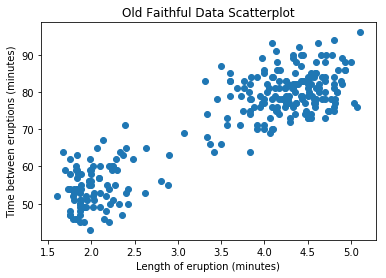

In [7]:
#https://www.springboard.com/blog/data-mining-python-tutorial/
plt.scatter(data.eruptions, data.waiting)
plt.title('Old Faithful Data Scatterplot')
plt.xlabel('Length of eruption (minutes)')
plt.ylabel('Time between eruptions (minutes)')

In [11]:
data = np.array(data)


In [ ]:
def gmm(X,K):
    # Num of data points N=271, Dimension D=2
    N, D = np.shape(X)
    
    #init centriods: K*D,2*2
    ctd_index = random.sample(range(272),2) 
    ctd = X[ctd_index] #pick K centriods randomly
    mean_vec1 = []
    mean_vec2 = []
    
    mean_vec1.append(ctd[0])
    mean_vec2.append(ctd[1])

    #Take initial guesses for μ1ˆ , sigma1ˆ 2, μ2ˆ , sigma2ˆ2, pieˆ 
    [pMiu,pPi,pSigma] = init_params(X,ctd,K,N,D)
    
    #set convergence threshold
    threshold  = 1e-15
    #previous log likelihood = -infinite
    Lprev = -np.inf
    
    while True:
        #------------------E-STEP compute responsibilities----------------------------
        
        #calculate Gaussian posterior probability of each component for each data point
        Px = calc_prob(pMiu,pSigma,X,K,N,D)
        #numerator = pi(k) * N(xi | pMiu(k), pSigma(k)) 
        pGamma = Px * np.tile(pPi,(N,1))
        #denominator= SUM(pi(j) * N(xi | pMiu(j), pSigma(j)))
        pGamma = pGamma / np.tile((np.sum(pGamma,axis=1)),(K,1)).T
        
        #------------------M-STEP update weighted means and variances----------------------------
        Nk = np.sum(pGamma,axis=0)
        #update pMiu
        pMiu = np.dot(np.dot(np.diag(1 / Nk),pGamma.T),X)
        mean_vec1.append(pMiu[0])
        mean_vec2.append(pMiu[1])
        
        #update pPi
        pPi = Nk / N
        #update pSigma
        for kk in range(K):
            Xshift = X - np.tile(pMiu[kk],(N,1))
            pSigma[:,:,kk] = (np.dot(np.dot(Xshift.T,np.diag(pGamma[:,kk])),Xshift)) / Nk[kk]
        
        #------------------CHECK FOR CONVERGENCE----------------------------
        L = np.sum(np.log(Px*(pPi.T)))  
        if L-Lprev < threshold:
            break        
        Lprev = L
        
    return Px, mean_vec1, mean_vec2

In [72]:
def guessParams(X,centroid,K,N,D):
    Miu = centroid;#2*2
    pPi = np.zeros([1, K]) #1*K, the weight of K components  
    pSigma = np.zeros([D, D, K]) #D*D*K, the cov matrix of k components
    
    distmat = np.tile(np.sum(X * X,axis=1),(K,1)).T 
    + np.tile(np.sum(Miu * Miu,axis = 1).T,(N,1)) 
    - 2 * np.dot(X,Miu.T)
    
    labels = np.argmin(distmat,axis=1)#label =  row index
    
    for k in range(K):
        Xk = X[labels==k]
        pPi[0][k] = float(np.shape(Xk)[0]) / N # (num of samples in component k) / N
        pSigma[:,:,k] = np.cov(Xk.T)
    
    return Miu,pPi,pSigma

    


In [73]:
def calc_prob(Miu,pSigma,X,K,N,D):
    Px = np.zeros((N,K))
    for k in range(K):
        Xshift = X - np.tile(Miu[k],(N,1))
        inv_pSigma = np.linalg.pinv(pSigma[:,:,k]) 
        tmp = np.sum(np.dot(Xshift,inv_pSigma) * Xshift,axis=1)
        coef = (2*np.pi)**(-D/2) * np.sqrt(np.linalg.det(inv_pSigma))
        Px[:,k] = coef * np.exp(-0.5 * tmp)
    return Px


In [ ]:
#if __name__ == '__main__':
    X = data[:,[0,1]] #discard data id
    scaler = preprocessing.MinMaxScaler()
    X = scaler.fit_transform(X) #data normalization-->range[0,1]
    
    esti_px, m_vec1, m_vec2 = GMM(X,2) #fit GMM
    index = np.argmax(esti_px,axis=1) 
    
    #plot the dataset after clustering
    plt.figure(1)
    plt.scatter(X[index==0][:,0],X[index==0][:,1],c='pink')
    plt.scatter(X[index==1][:,0],X[index==1][:,1],c=u'b')
    
    #plot the trajectories of two mean vectors
    plt.plot(np.mat(m_vec1)[:,0],np.mat(m_vec1)[:,1],'rv-',markersize=10,linewidth=5)
    plt.plot(np.mat(m_vec2)[:,0],np.mat(m_vec2)[:,1],'mD-',markersize=10,linewidth=5)
    
    plt.title(" Clustering using bimodel GMM")
    #plt.savefig("gmm.jpg")